# ImageNet Object Localization Challenge Dataset Explorer 🔍

## Dataset Overview
- **Source**: Kaggle ImageNet Object Localization Challenge
- **Location**: `/home/ubuntu/Downloads/`
- **Classes**: 1000 object categories
- **Task**: Object classification and localization

## Dataset Structure (ILSVRC Format)
```
ILSVRC/
├── Data/
│   └── CLS-LOC/
│       ├── train/           # Training images (1000 class folders)
│       ├── val/             # Validation images (50,000 images)
│       └── test/            # Test images (100,000 images)
├── Annotations/
│   └── CLS-LOC/
│       ├── train/           # Training bounding box annotations (XML)
│       └── val/             # Validation bounding box annotations (XML)
└── ImageSets/
    └── CLS-LOC/
        ├── train_cls.txt    # Training image list
        ├── val.txt          # Validation image list
        └── test.txt         # Test image list
```

This notebook provides step-by-step exploration of the ImageNet dataset.

In [1]:
# Step 1: Import Required Libraries
import os
import glob
import random
import xml.etree.ElementTree as ET
from pathlib import Path
from collections import Counter, defaultdict

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import seaborn as sns
from PIL import Image
from tqdm import tqdm

# Set plotting style
plt.rcParams['figure.figsize'] = (12, 8)
sns.set_style("whitegrid")

print("✅ Libraries imported successfully!")

✅ Libraries imported successfully!


In [2]:
# Step 2: Set Dataset Paths
# Update this path to where you extracted the ImageNet dataset
DATASET_ROOT = "/home/ubuntu/Downloads/ILSVRC"  # Main extracted folder

# Define key directories
DATA_DIR = os.path.join(DATASET_ROOT, "Data", "CLS-LOC")
ANNOTATIONS_DIR = os.path.join(DATASET_ROOT, "Annotations", "CLS-LOC")
IMAGESETS_DIR = os.path.join(DATASET_ROOT, "ImageSets", "CLS-LOC")

TRAIN_DIR = os.path.join(DATA_DIR, "train")
VAL_DIR = os.path.join(DATA_DIR, "val")
TEST_DIR = os.path.join(DATA_DIR, "test")

TRAIN_ANNOTATIONS_DIR = os.path.join(ANNOTATIONS_DIR, "train")
VAL_ANNOTATIONS_DIR = os.path.join(ANNOTATIONS_DIR, "val")

print(f"📁 Dataset root: {DATASET_ROOT}")
print(f"📁 Data directory: {DATA_DIR}")
print(f"📁 Annotations directory: {ANNOTATIONS_DIR}")
print(f"📁 ImageSets directory: {IMAGESETS_DIR}")

# Check if directories exist
directories = {
    "Dataset Root": DATASET_ROOT,
    "Train Images": TRAIN_DIR,
    "Val Images": VAL_DIR,
    "Test Images": TEST_DIR,
    "Train Annotations": TRAIN_ANNOTATIONS_DIR,
    "Val Annotations": VAL_ANNOTATIONS_DIR,
    "ImageSets": IMAGESETS_DIR
}

for name, path in directories.items():
    if os.path.exists(path):
        print(f"✅ {name}: Found")
    else:
        print(f"❌ {name}: Not found at {path}")

📁 Dataset root: /home/ubuntu/Downloads/ILSVRC
📁 Data directory: /home/ubuntu/Downloads/ILSVRC/Data/CLS-LOC
📁 Annotations directory: /home/ubuntu/Downloads/ILSVRC/Annotations/CLS-LOC
📁 ImageSets directory: /home/ubuntu/Downloads/ILSVRC/ImageSets/CLS-LOC
✅ Dataset Root: Found
✅ Train Images: Found
✅ Val Images: Found
✅ Test Images: Found
✅ Train Annotations: Found
✅ Val Annotations: Found
✅ ImageSets: Found


In [3]:
# Step 3: Load ImageNet Class Information
# ImageNet classes follow WordNet synset IDs (e.g., n01440764)

def load_class_names():
    """Load ImageNet class names from training directory structure"""
    class_info = {}
    
    if os.path.exists(TRAIN_DIR):
        class_dirs = [d for d in os.listdir(TRAIN_DIR) 
                     if os.path.isdir(os.path.join(TRAIN_DIR, d))]
        
        for i, class_dir in enumerate(sorted(class_dirs)):
            class_info[class_dir] = {
                'synset_id': class_dir,
                'class_index': i,
                'class_name': class_dir  # Will be synset ID if no mapping available
            }
    
    return class_info

# Load class information
class_info = load_class_names()
print(f"📊 Found {len(class_info)} classes")

# Display first 10 classes
if class_info:
    print("\n🔍 First 10 classes:")
    for i, (synset, info) in enumerate(list(class_info.items())[:10]):
        print(f"  {i+1:3d}. {synset}")
else:
    print("⚠️ No classes found. Check if the dataset is properly extracted.")

📊 Found 1000 classes

🔍 First 10 classes:
    1. n01440764
    2. n01443537
    3. n01484850
    4. n01491361
    5. n01494475
    6. n01496331
    7. n01498041
    8. n01514668
    9. n01514859
   10. n01518878


In [4]:
# Step 4: Analyze Dataset Structure and Statistics

def analyze_dataset_structure():
    """Analyze the structure and get basic statistics"""
    stats = {
        'train': {'classes': 0, 'images': 0, 'total_size_gb': 0},
        'val': {'classes': 0, 'images': 0, 'total_size_gb': 0},
        'test': {'classes': 0, 'images': 0, 'total_size_gb': 0}
    }
    
    # Analyze training set
    if os.path.exists(TRAIN_DIR):
        train_classes = [d for d in os.listdir(TRAIN_DIR) 
                        if os.path.isdir(os.path.join(TRAIN_DIR, d))]
        stats['train']['classes'] = len(train_classes)
        
        # Count images per class (sample first 10 classes for speed)
        total_train_images = 0
        sample_classes = train_classes[:10] if len(train_classes) > 10 else train_classes
        
        for class_dir in sample_classes:
            class_path = os.path.join(TRAIN_DIR, class_dir)
            images = [f for f in os.listdir(class_path) 
                     if f.lower().endswith(('.jpg', '.jpeg', '.png'))]
            total_train_images += len(images)
        
        # Estimate total images (extrapolate from sample)
        if sample_classes:
            avg_per_class = total_train_images / len(sample_classes)
            stats['train']['images'] = int(avg_per_class * len(train_classes))
    
    # Analyze validation set
    if os.path.exists(VAL_DIR):
        val_images = [f for f in os.listdir(VAL_DIR) 
                     if f.lower().endswith(('.jpg', '.jpeg', '.png'))]
        stats['val']['images'] = len(val_images)
        stats['val']['classes'] = 1000  # Val images are in single directory
    
    # Analyze test set
    if os.path.exists(TEST_DIR):
        test_images = [f for f in os.listdir(TEST_DIR) 
                      if f.lower().endswith(('.jpg', '.jpeg', '.png'))]
        stats['test']['images'] = len(test_images)
        stats['test']['classes'] = 1000  # Test images are in single directory
    
    return stats

# Get dataset statistics
print("🔍 Analyzing dataset structure...")
dataset_stats = analyze_dataset_structure()

# Display statistics
print("\n📊 Dataset Statistics:")
print("=" * 50)
for split, stats in dataset_stats.items():
    print(f"{split.upper():>8}: {stats['classes']:,} classes, {stats['images']:,} images")

# Total images
total_images = sum(stats['images'] for stats in dataset_stats.values())
print(f"{'TOTAL':>8}: {total_images:,} images")

🔍 Analyzing dataset structure...

📊 Dataset Statistics:
   TRAIN: 1,000 classes, 1,273,100 images
     VAL: 1,000 classes, 50,000 images
    TEST: 1,000 classes, 100,000 images
   TOTAL: 1,423,100 images


📊 Analyzing 1000 training classes...


Analyzing classes: 100%|██████████| 50/50 [00:00<00:00, 1296.03it/s]


📈 Training Set Analysis (Sample of 50 classes):
Average images per class: 1258.9
Min images per class: 969
Max images per class: 1300
Total images (sample): 62,946


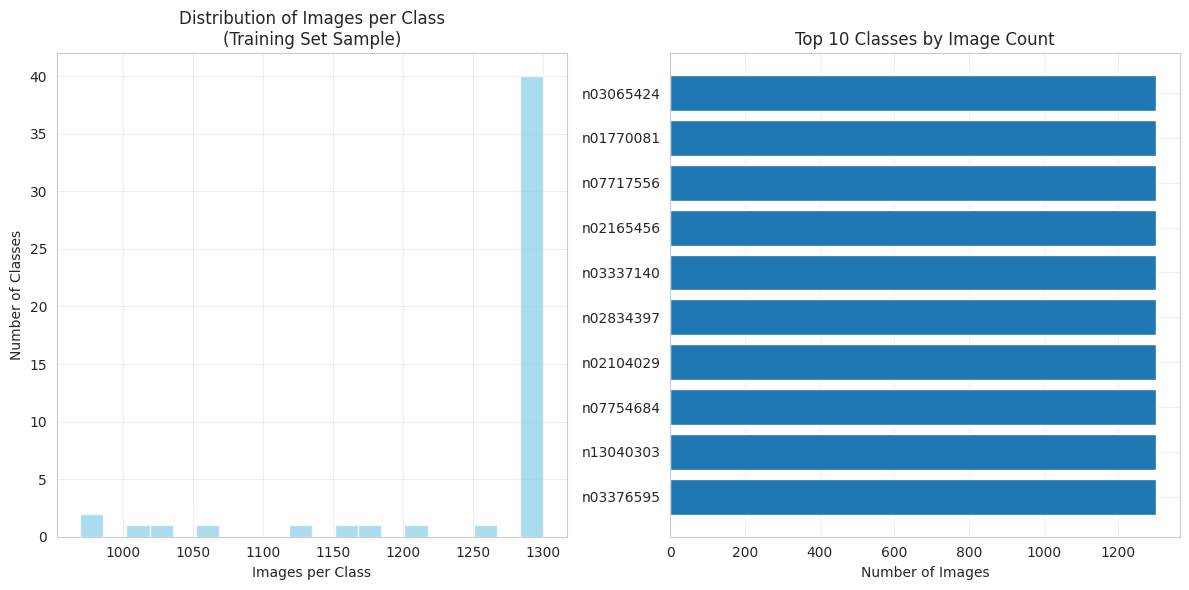

In [5]:
# Step 5: Explore Training Set - Images per Class Distribution

def analyze_training_distribution():
    """Analyze the distribution of images per class in training set"""
    if not os.path.exists(TRAIN_DIR):
        print("❌ Training directory not found")
        return None
    
    class_counts = []
    class_names = []
    
    # Get list of class directories
    train_classes = [d for d in os.listdir(TRAIN_DIR) 
                    if os.path.isdir(os.path.join(TRAIN_DIR, d))]
    
    print(f"📊 Analyzing {len(train_classes)} training classes...")
    
    # Sample classes for faster analysis (or use all if small dataset)
    sample_size = min(50, len(train_classes))  # Analyze first 50 classes
    sample_classes = train_classes[:sample_size]
    
    for class_dir in tqdm(sample_classes, desc="Analyzing classes"):
        class_path = os.path.join(TRAIN_DIR, class_dir)
        images = [f for f in os.listdir(class_path) 
                 if f.lower().endswith(('.jpg', '.jpeg', '.png'))]
        class_counts.append(len(images))
        class_names.append(class_dir)
    
    return pd.DataFrame({
        'class': class_names,
        'image_count': class_counts
    })

# Analyze training distribution
train_df = analyze_training_distribution()

if train_df is not None:
    # Display statistics
    print(f"\n📈 Training Set Analysis (Sample of {len(train_df)} classes):")
    print(f"Average images per class: {train_df['image_count'].mean():.1f}")
    print(f"Min images per class: {train_df['image_count'].min()}")
    print(f"Max images per class: {train_df['image_count'].max()}")
    print(f"Total images (sample): {train_df['image_count'].sum():,}")
    
    # Plot distribution
    plt.figure(figsize=(12, 6))
    
    plt.subplot(1, 2, 1)
    plt.hist(train_df['image_count'], bins=20, alpha=0.7, color='skyblue')
    plt.xlabel('Images per Class')
    plt.ylabel('Number of Classes')
    plt.title('Distribution of Images per Class\n(Training Set Sample)')
    plt.grid(True, alpha=0.3)
    
    plt.subplot(1, 2, 2)
    # Top 10 classes by image count
    top_classes = train_df.nlargest(10, 'image_count')
    plt.barh(range(len(top_classes)), top_classes['image_count'])
    plt.yticks(range(len(top_classes)), 
               [c[:15] + '...' if len(c) > 15 else c for c in top_classes['class']])
    plt.xlabel('Number of Images')
    plt.title('Top 10 Classes by Image Count')
    plt.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()

🖼️ Displaying sample images from random classes...


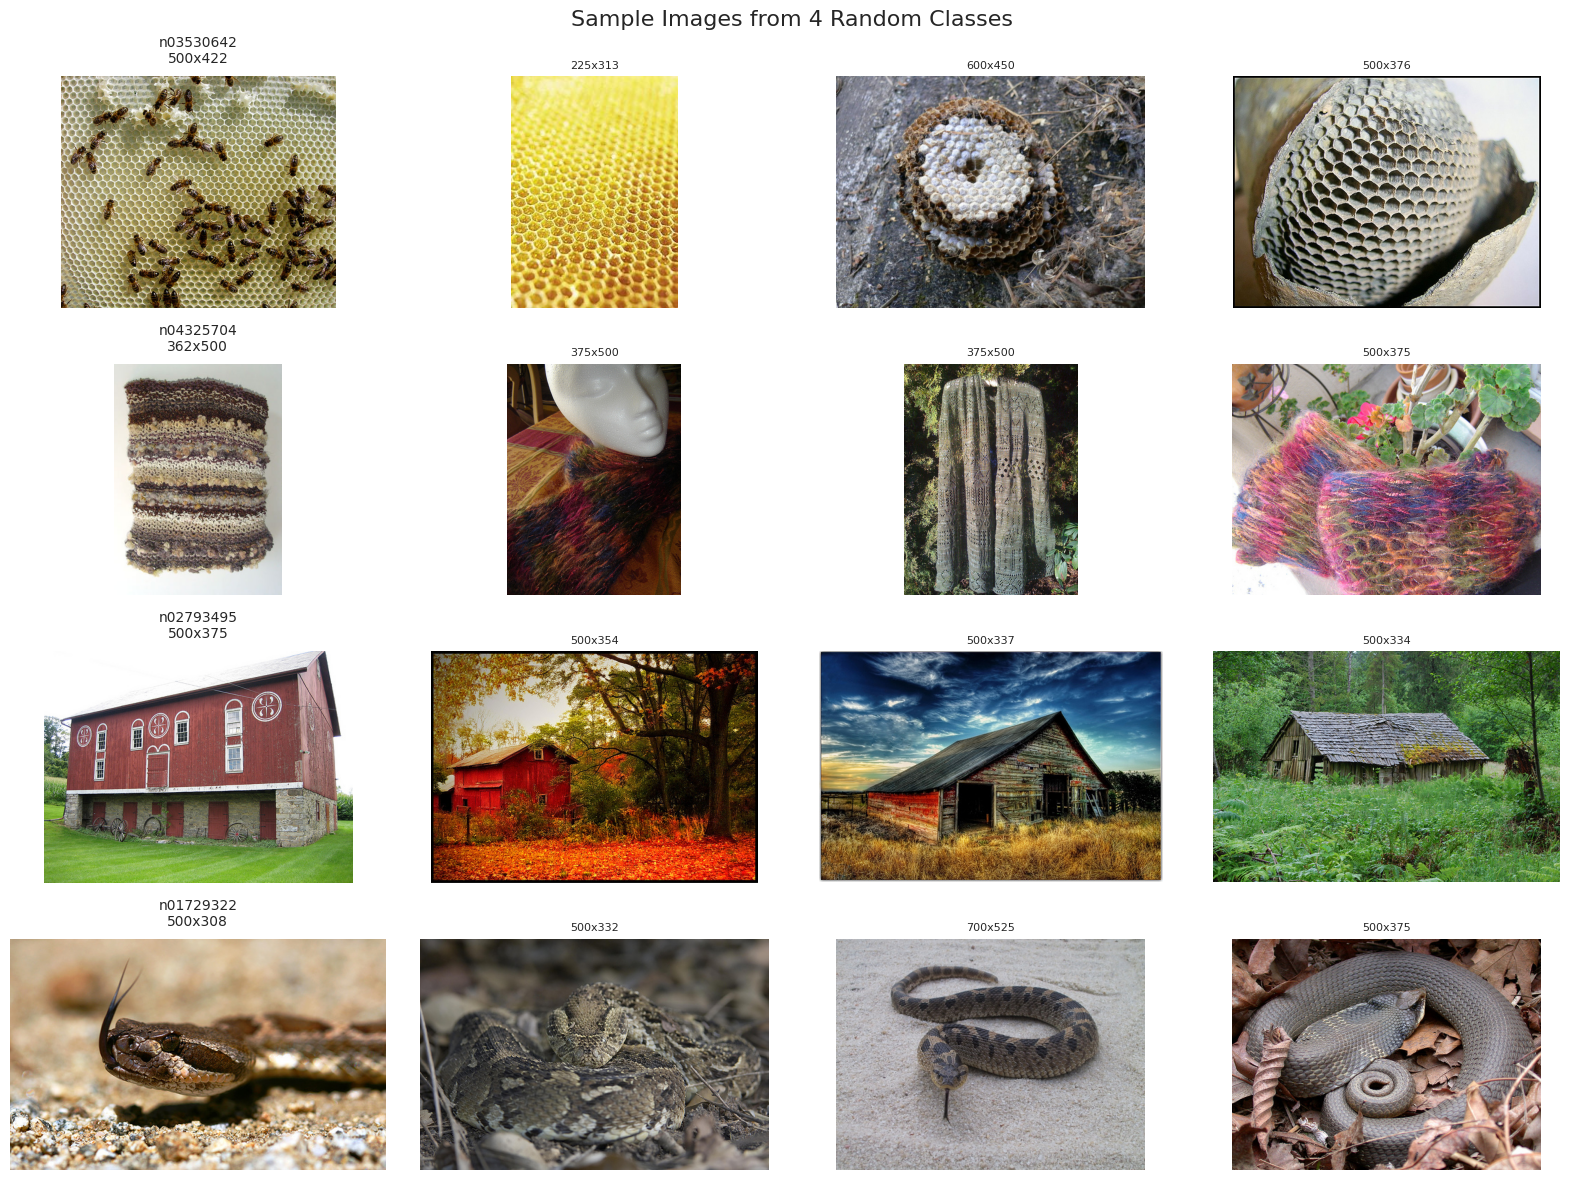

In [6]:
# Step 6: Sample Image Exploration

def display_sample_images(num_classes=6, images_per_class=4):
    """Display sample images from different classes"""
    if not os.path.exists(TRAIN_DIR):
        print("❌ Training directory not found")
        return
    
    # Get list of classes
    train_classes = [d for d in os.listdir(TRAIN_DIR) 
                    if os.path.isdir(os.path.join(TRAIN_DIR, d))]
    
    # Randomly sample classes
    sample_classes = random.sample(train_classes, min(num_classes, len(train_classes)))
    
    fig, axes = plt.subplots(num_classes, images_per_class, 
                            figsize=(4*images_per_class, 3*num_classes))
    
    if num_classes == 1:
        axes = axes.reshape(1, -1)
    
    for i, class_dir in enumerate(sample_classes):
        class_path = os.path.join(TRAIN_DIR, class_dir)
        
        # Get image files
        image_files = [f for f in os.listdir(class_path) 
                      if f.lower().endswith(('.jpg', '.jpeg', '.png'))]
        
        # Sample images
        sample_images = random.sample(image_files, 
                                     min(images_per_class, len(image_files)))
        
        for j, img_file in enumerate(sample_images):
            img_path = os.path.join(class_path, img_file)
            
            try:
                # Load and display image
                img = Image.open(img_path)
                
                axes[i, j].imshow(img)
                axes[i, j].axis('off')
                
                if j == 0:  # Add class name to first image
                    axes[i, j].set_title(f"{class_dir}\n{img.size[0]}x{img.size[1]}", 
                                        fontsize=10, pad=10)
                else:
                    axes[i, j].set_title(f"{img.size[0]}x{img.size[1]}", 
                                        fontsize=8)
                
            except Exception as e:
                axes[i, j].text(0.5, 0.5, f"Error loading\n{img_file}", 
                               ha='center', va='center', transform=axes[i, j].transAxes)
                axes[i, j].axis('off')
        
        # Hide unused subplots
        for j in range(len(sample_images), images_per_class):
            axes[i, j].axis('off')
    
    plt.suptitle(f'Sample Images from {num_classes} Random Classes', fontsize=16, y=0.98)
    plt.tight_layout()
    plt.show()

# Display sample images
print("🖼️ Displaying sample images from random classes...")
display_sample_images(num_classes=4, images_per_class=4)

🔍 Analyzing properties of 200 sample images...

📊 Image Properties Analysis (200 images):
Width  - Min: 50, Max: 1000, Mean: 464.8
Height - Min: 50, Max: 750, Mean: 383.7
File Size (KB) - Min: 1.4, Max: 256.3, Mean: 113.5
Aspect Ratio - Min: 0.52, Max: 2.66, Mean: 1.26

Formats: {'JPEG': 200}
Modes: {'RGB': 193, 'L': 7}


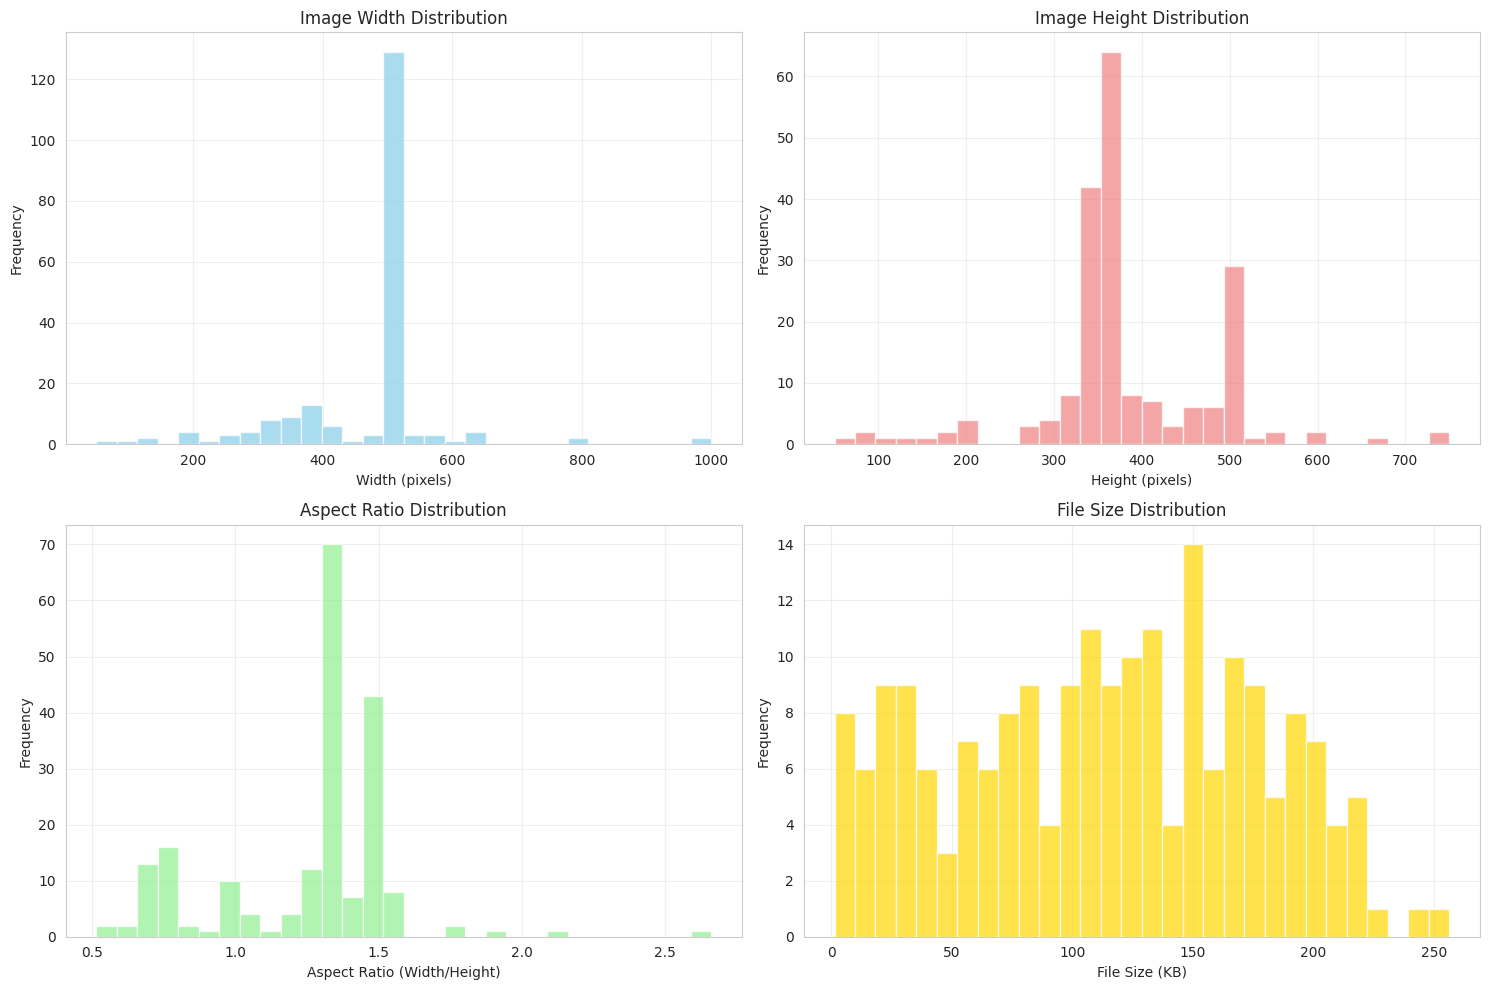

In [7]:
# Step 7: Analyze Image Properties

def analyze_image_properties(num_samples=200):
    """Analyze properties of sample images (size, format, etc.)"""
    if not os.path.exists(TRAIN_DIR):
        print("❌ Training directory not found")
        return
    
    image_info = []
    
    # Get list of classes
    train_classes = [d for d in os.listdir(TRAIN_DIR) 
                    if os.path.isdir(os.path.join(TRAIN_DIR, d))]
    
    # Sample images from different classes
    sample_classes = random.sample(train_classes, min(10, len(train_classes)))
    
    print(f"🔍 Analyzing properties of {num_samples} sample images...")
    
    samples_collected = 0
    
    for class_dir in sample_classes:
        if samples_collected >= num_samples:
            break
            
        class_path = os.path.join(TRAIN_DIR, class_dir)
        image_files = [f for f in os.listdir(class_path) 
                      if f.lower().endswith(('.jpg', '.jpeg', '.png'))]
        
        # Sample images from this class
        class_samples = min(num_samples // len(sample_classes), len(image_files))
        sample_images = random.sample(image_files, class_samples)
        
        for img_file in sample_images:
            try:
                img_path = os.path.join(class_path, img_file)
                img = Image.open(img_path)
                
                # Get file size
                file_size_kb = os.path.getsize(img_path) / 1024
                
                image_info.append({
                    'class': class_dir,
                    'filename': img_file,
                    'width': img.size[0],
                    'height': img.size[1],
                    'format': img.format,
                    'mode': img.mode,
                    'file_size_kb': file_size_kb,
                    'aspect_ratio': img.size[0] / img.size[1]
                })
                
                img.close()
                samples_collected += 1
                
            except Exception as e:
                print(f"⚠️ Error processing {img_file}: {e}")
    
    if not image_info:
        print("❌ No images could be analyzed")
        return
    
    # Convert to DataFrame
    df = pd.DataFrame(image_info)
    
    # Display statistics
    print(f"\n📊 Image Properties Analysis ({len(df)} images):")
    print("=" * 50)
    print(f"Width  - Min: {df['width'].min()}, Max: {df['width'].max()}, Mean: {df['width'].mean():.1f}")
    print(f"Height - Min: {df['height'].min()}, Max: {df['height'].max()}, Mean: {df['height'].mean():.1f}")
    print(f"File Size (KB) - Min: {df['file_size_kb'].min():.1f}, Max: {df['file_size_kb'].max():.1f}, Mean: {df['file_size_kb'].mean():.1f}")
    print(f"Aspect Ratio - Min: {df['aspect_ratio'].min():.2f}, Max: {df['aspect_ratio'].max():.2f}, Mean: {df['aspect_ratio'].mean():.2f}")
    
    print(f"\nFormats: {df['format'].value_counts().to_dict()}")
    print(f"Modes: {df['mode'].value_counts().to_dict()}")
    
    # Create visualizations
    fig, axes = plt.subplots(2, 2, figsize=(15, 10))
    
    # Width distribution
    axes[0, 0].hist(df['width'], bins=30, alpha=0.7, color='skyblue')
    axes[0, 0].set_xlabel('Width (pixels)')
    axes[0, 0].set_ylabel('Frequency')
    axes[0, 0].set_title('Image Width Distribution')
    axes[0, 0].grid(True, alpha=0.3)
    
    # Height distribution
    axes[0, 1].hist(df['height'], bins=30, alpha=0.7, color='lightcoral')
    axes[0, 1].set_xlabel('Height (pixels)')
    axes[0, 1].set_ylabel('Frequency')
    axes[0, 1].set_title('Image Height Distribution')
    axes[0, 1].grid(True, alpha=0.3)
    
    # Aspect ratio distribution
    axes[1, 0].hist(df['aspect_ratio'], bins=30, alpha=0.7, color='lightgreen')
    axes[1, 0].set_xlabel('Aspect Ratio (Width/Height)')
    axes[1, 0].set_ylabel('Frequency')
    axes[1, 0].set_title('Aspect Ratio Distribution')
    axes[1, 0].grid(True, alpha=0.3)
    
    # File size distribution
    axes[1, 1].hist(df['file_size_kb'], bins=30, alpha=0.7, color='gold')
    axes[1, 1].set_xlabel('File Size (KB)')
    axes[1, 1].set_ylabel('Frequency')
    axes[1, 1].set_title('File Size Distribution')
    axes[1, 1].grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    return df

# Analyze image properties
image_props_df = analyze_image_properties(num_samples=200)

In [ ]:
# Step 7.1: Calculate RGB Normalization Values for Training

def calculate_rgb_normalization_values(num_samples=1000, sample_classes=20):
    """
    Calculate RGB channel mean and standard deviation for dataset normalization
    These values are essential for proper model training preprocessing
    """
    if not os.path.exists(TRAIN_DIR):
        print("❌ Training directory not found")
        return None, None
    
    print(f"🔢 Calculating RGB normalization values...")
    print(f"📊 Sampling {num_samples} images from {sample_classes} classes")
    
    # Get list of classes
    train_classes = [d for d in os.listdir(TRAIN_DIR) 
                    if os.path.isdir(os.path.join(TRAIN_DIR, d))]
    
    if len(train_classes) == 0:
        print("❌ No training classes found")
        return None, None
    
    # Sample classes for analysis
    sample_class_list = random.sample(train_classes, min(sample_classes, len(train_classes)))
    
    # Collect pixel values for each channel
    r_values = []
    g_values = []
    b_values = []
    
    samples_collected = 0
    samples_per_class = max(1, num_samples // len(sample_class_list))
    
    print("🔍 Processing images...")
    
    for class_dir in tqdm(sample_class_list, desc="Processing classes"):
        if samples_collected >= num_samples:
            break
            
        class_path = os.path.join(TRAIN_DIR, class_dir)
        image_files = [f for f in os.listdir(class_path) 
                      if f.lower().endswith(('.jpg', '.jpeg', '.png'))]
        
        if not image_files:
            continue
            
        # Sample images from this class
        class_sample_size = min(samples_per_class, len(image_files), num_samples - samples_collected)
        sample_images = random.sample(image_files, class_sample_size)
        
        for img_file in sample_images:
            if samples_collected >= num_samples:
                break
                
            try:
                img_path = os.path.join(class_path, img_file)
                img = Image.open(img_path).convert('RGB')
                
                # Resize to standard size to avoid memory issues
                img = img.resize((224, 224))
                
                # Convert to numpy array and normalize to [0, 1]
                img_array = np.array(img, dtype=np.float32) / 255.0
                
                # Collect pixel values for each channel
                r_values.extend(img_array[:, :, 0].flatten())
                g_values.extend(img_array[:, :, 1].flatten())
                b_values.extend(img_array[:, :, 2].flatten())
                
                samples_collected += 1
                img.close()
                
            except Exception as e:
                print(f"⚠️ Error processing {img_file}: {e}")
                continue
    
    if not r_values:
        print("❌ No valid images processed")
        return None, None
    
    # Calculate statistics
    r_values = np.array(r_values)
    g_values = np.array(g_values)
    b_values = np.array(b_values)
    
    # Calculate means and standard deviations
    mean_r = np.mean(r_values)
    mean_g = np.mean(g_values)
    mean_b = np.mean(b_values)
    
    std_r = np.std(r_values)
    std_g = np.std(g_values)
    std_b = np.std(b_values)
    
    means = [mean_r, mean_g, mean_b]
    stds = [std_r, std_g, std_b]
    
    # Display results
    print(f"\n📊 RGB Normalization Statistics ({samples_collected:,} images processed):")
    print("=" * 60)
    print(f"🔴 Red   Channel - Mean: {mean_r:.6f}, Std: {std_r:.6f}")
    print(f"🟢 Green Channel - Mean: {mean_g:.6f}, Std: {std_g:.6f}")
    print(f"🔵 Blue  Channel - Mean: {mean_b:.6f}, Std: {std_b:.6f}")
    
    print(f"\n🎯 PyTorch Normalization Values:")
    print("=" * 40)
    print(f"mean = {means}")
    print(f"std  = {stds}")
    
    print(f"\n📋 Ready-to-use PyTorch Transform:")
    print("=" * 40)
    print("transforms.Normalize(")
    print(f"    mean=[{mean_r:.6f}, {mean_g:.6f}, {mean_b:.6f}],")
    print(f"    std=[{std_r:.6f}, {std_g:.6f}, {std_b:.6f}]")
    print(")")
    
    # Compare with ImageNet standard values
    imagenet_mean = [0.485, 0.456, 0.406]
    imagenet_std = [0.229, 0.224, 0.225]
    
    print(f"\n📊 Comparison with ImageNet Standard Values:")
    print("=" * 50)
    print("Channel |   Your Dataset   |   ImageNet Std   |   Difference")
    print("--------|------------------|------------------|-------------")
    print(f"Red     | {mean_r:.6f}      | {imagenet_mean[0]:.6f}      | {abs(mean_r - imagenet_mean[0]):.6f}")
    print(f"Green   | {mean_g:.6f}      | {imagenet_mean[1]:.6f}      | {abs(mean_g - imagenet_mean[1]):.6f}")
    print(f"Blue    | {mean_b:.6f}      | {imagenet_std[2]:.6f}      | {abs(mean_b - imagenet_mean[2]):.6f}")
    
    print(f"\n💡 Recommendations:")
    if all(abs(means[i] - imagenet_mean[i]) < 0.05 for i in range(3)):
        print("✅ Your dataset values are close to ImageNet standard values")
        print("✅ You can use ImageNet normalization: mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]")
    else:
        print("⚠️ Your dataset values differ from ImageNet standard")
        print("💡 Consider using your calculated values for better performance")
        print("💡 Or use ImageNet values if using pretrained models")
    
    # Visualize the distributions
    fig, axes = plt.subplots(2, 2, figsize=(15, 10))
    
    # RGB distribution histogram
    axes[0, 0].hist(r_values, bins=50, alpha=0.7, color='red', label='Red', density=True)
    axes[0, 0].hist(g_values, bins=50, alpha=0.7, color='green', label='Green', density=True)
    axes[0, 0].hist(b_values, bins=50, alpha=0.7, color='blue', label='Blue', density=True)
    axes[0, 0].set_xlabel('Pixel Value (0-1)')
    axes[0, 0].set_ylabel('Density')
    axes[0, 0].set_title('RGB Channel Distributions')
    axes[0, 0].legend()
    axes[0, 0].grid(True, alpha=0.3)
    
    # Mean comparison
    channels = ['Red', 'Green', 'Blue']
    x_pos = np.arange(len(channels))
    
    axes[0, 1].bar(x_pos - 0.2, means, 0.4, label='Your Dataset', alpha=0.8)
    axes[0, 1].bar(x_pos + 0.2, imagenet_mean, 0.4, label='ImageNet Standard', alpha=0.8)
    axes[0, 1].set_xlabel('RGB Channels')
    axes[0, 1].set_ylabel('Mean Value')
    axes[0, 1].set_title('Mean Values Comparison')
    axes[0, 1].set_xticks(x_pos)
    axes[0, 1].set_xticklabels(channels)
    axes[0, 1].legend()
    axes[0, 1].grid(True, alpha=0.3)
    
    # Std comparison
    axes[1, 0].bar(x_pos - 0.2, stds, 0.4, label='Your Dataset', alpha=0.8)
    axes[1, 0].bar(x_pos + 0.2, imagenet_std, 0.4, label='ImageNet Standard', alpha=0.8)
    axes[1, 0].set_xlabel('RGB Channels')
    axes[1, 0].set_ylabel('Standard Deviation')
    axes[1, 0].set_title('Standard Deviation Comparison')
    axes[1, 0].set_xticks(x_pos)
    axes[1, 0].set_xticklabels(channels)
    axes[1, 0].legend()
    axes[1, 0].grid(True, alpha=0.3)
    
    # Sample normalized vs original
    if samples_collected > 0:
        # Show effect of normalization on a sample image
        sample_class = sample_class_list[0]
        sample_class_path = os.path.join(TRAIN_DIR, sample_class)
        sample_img_files = [f for f in os.listdir(sample_class_path) 
                           if f.lower().endswith(('.jpg', '.jpeg', '.png'))]
        
        if sample_img_files:
            try:
                sample_img_path = os.path.join(sample_class_path, sample_img_files[0])
                sample_img = Image.open(sample_img_path).convert('RGB')
                sample_img = sample_img.resize((224, 224))
                
                # Original image
                sample_array = np.array(sample_img, dtype=np.float32) / 255.0
                
                # Normalized image
                normalized_array = (sample_array - np.array(means).reshape(1, 1, 3)) / np.array(stds).reshape(1, 1, 3)
                
                axes[1, 1].imshow(sample_array)
                axes[1, 1].set_title('Sample Image\n(Original - Scaled to [0,1])')
                axes[1, 1].axis('off')
                
            except Exception as e:
                axes[1, 1].text(0.5, 0.5, f"Error loading\nsample image\n{str(e)[:30]}", 
                               ha='center', va='center', transform=axes[1, 1].transAxes)
                axes[1, 1].axis('off')
    
    plt.tight_layout()
    plt.show()
    
    return means, stds

# Calculate RGB normalization values
print("🔢 Calculating RGB normalization values for your dataset...")
calculated_means, calculated_stds = calculate_rgb_normalization_values(num_samples=1000, sample_classes=20)

📊 Validation Set Analysis:
Total validation images: 50,000


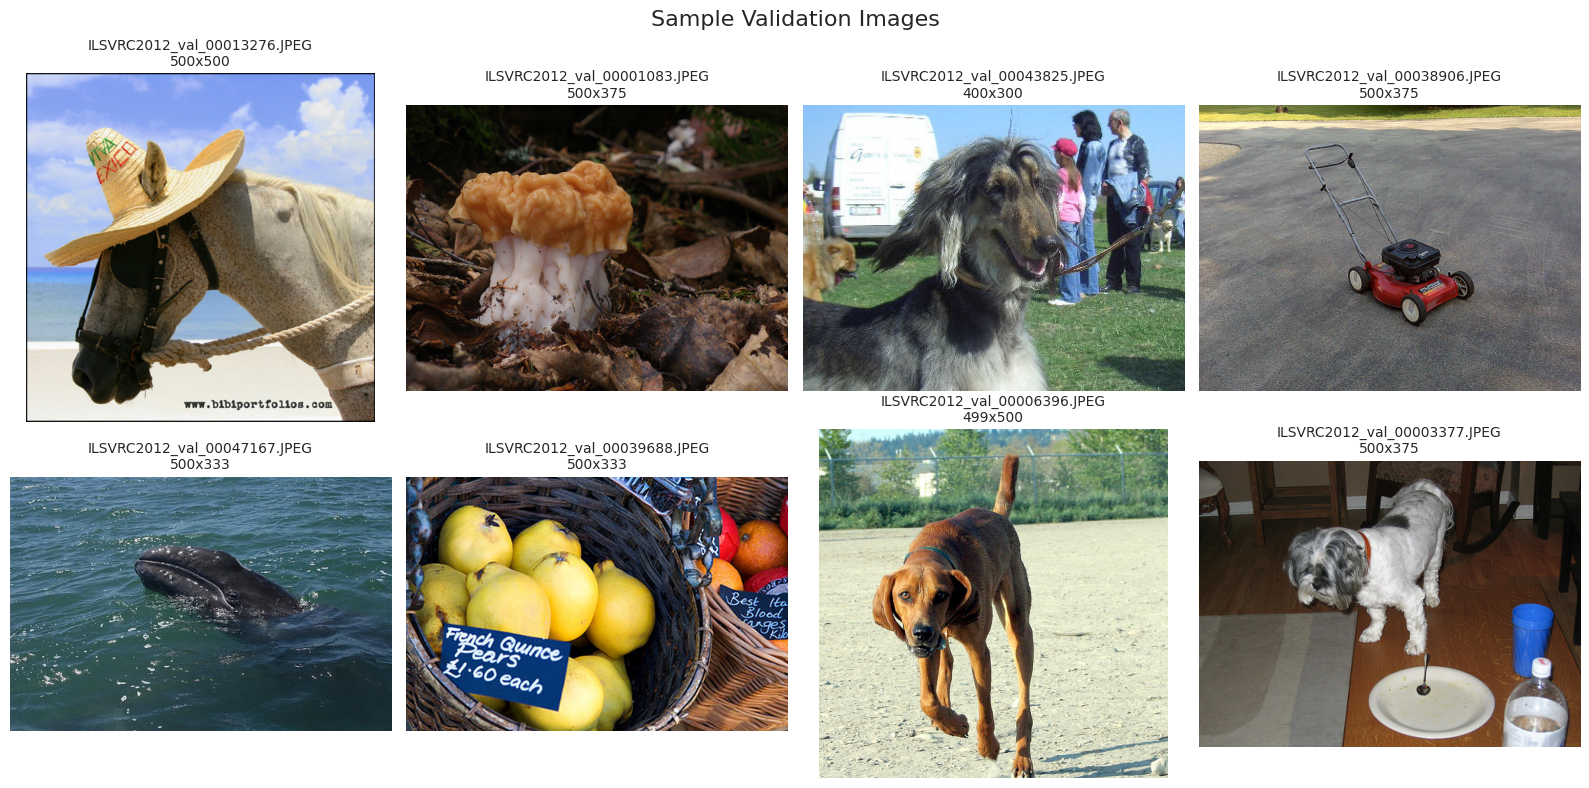

✅ Validation ground truth file found: /home/ubuntu/Downloads/ILSVRC/ImageSets/CLS-LOC/val.txt

📄 Sample validation ground truth entries:
  ILSVRC2012_val_00000001 1
  ILSVRC2012_val_00000002 2
  ILSVRC2012_val_00000003 3
  ILSVRC2012_val_00000004 4
  ILSVRC2012_val_00000005 5
  ILSVRC2012_val_00000006 6
  ILSVRC2012_val_00000007 7
  ILSVRC2012_val_00000008 8
  ILSVRC2012_val_00000009 9
  ILSVRC2012_val_00000010 10


In [8]:
# Step 8: Explore Validation Set

def analyze_validation_set():
    """Analyze the validation set structure"""
    if not os.path.exists(VAL_DIR):
        print("❌ Validation directory not found")
        return
    
    # Get validation images
    val_images = [f for f in os.listdir(VAL_DIR) 
                 if f.lower().endswith(('.jpg', '.jpeg', '.png'))]
    
    print(f"📊 Validation Set Analysis:")
    print(f"Total validation images: {len(val_images):,}")
    
    # Sample some validation images
    if val_images:
        sample_images = random.sample(val_images, min(8, len(val_images)))
        
        fig, axes = plt.subplots(2, 4, figsize=(16, 8))
        axes = axes.flatten()
        
        for i, img_file in enumerate(sample_images):
            try:
                img_path = os.path.join(VAL_DIR, img_file)
                img = Image.open(img_path)
                
                axes[i].imshow(img)
                axes[i].set_title(f"{img_file}\n{img.size[0]}x{img.size[1]}", fontsize=10)
                axes[i].axis('off')
                
                img.close()
                
            except Exception as e:
                axes[i].text(0.5, 0.5, f"Error loading\n{img_file}", 
                           ha='center', va='center', transform=axes[i].transAxes)
                axes[i].axis('off')
        
        plt.suptitle('Sample Validation Images', fontsize=16)
        plt.tight_layout()
        plt.show()
    
    # Check if validation ground truth file exists
    val_gt_file = os.path.join(IMAGESETS_DIR, "val.txt")
    if os.path.exists(val_gt_file):
        print(f"✅ Validation ground truth file found: {val_gt_file}")
        
        # Read first few lines
        with open(val_gt_file, 'r') as f:
            lines = f.readlines()[:10]
            print("\n📄 Sample validation ground truth entries:")
            for line in lines:
                print(f"  {line.strip()}")
    else:
        print(f"❌ Validation ground truth file not found: {val_gt_file}")

# Analyze validation set
analyze_validation_set()

🔍 Exploring annotation files...
✅ Training annotations directory found
📄 Found 431 annotation files in class 'n02916936'

📊 Annotation Analysis (Sample of 6 files):
Objects per image - Min: 1, Max: 1, Mean: 1.0


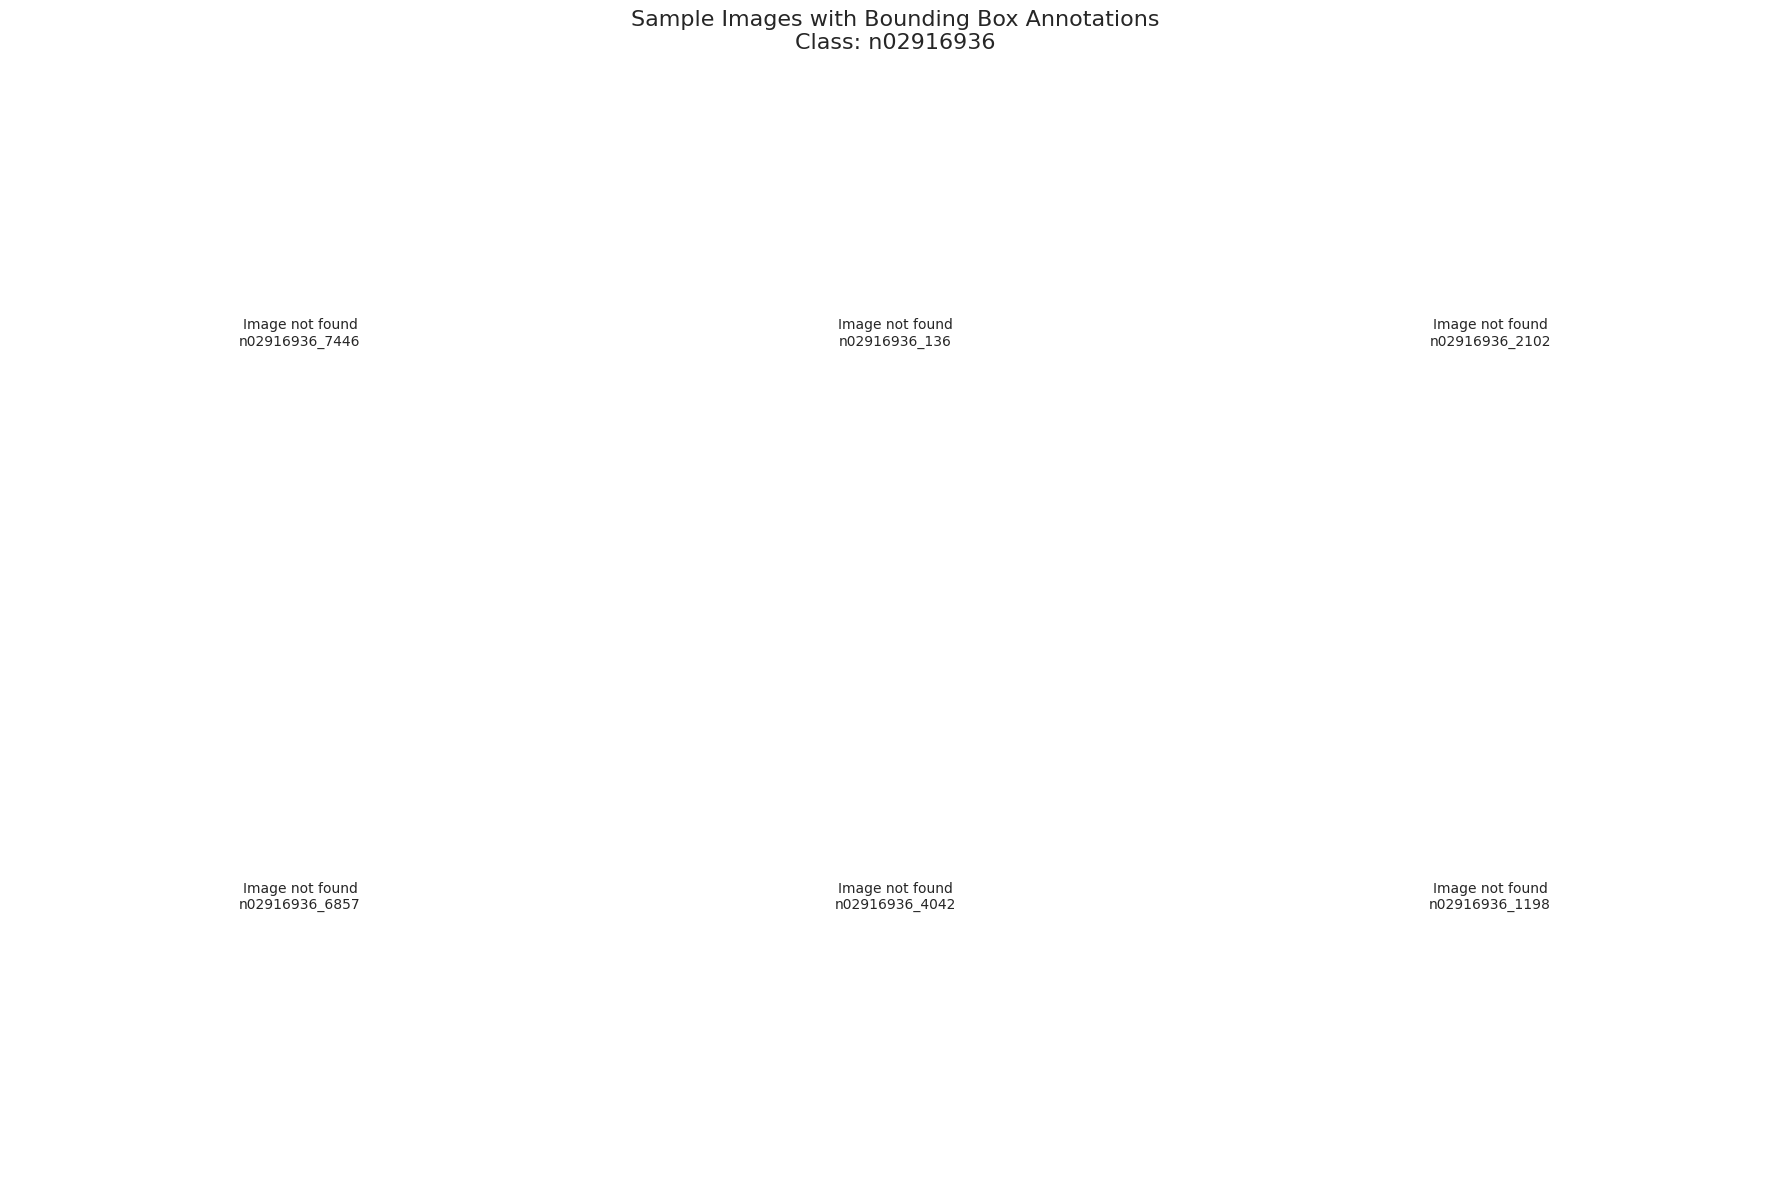

In [10]:
# Step 9: Explore Annotations (Bounding Boxes)

def parse_annotation_xml(xml_file):
    """Parse ImageNet annotation XML file"""
    try:
        tree = ET.parse(xml_file)
        root = tree.getroot()
        
        # Get image info
        filename = root.find('filename').text if root.find('filename') is not None else 'unknown'
        
        size_elem = root.find('size')
        if size_elem is not None:
            width = int(size_elem.find('width').text)
            height = int(size_elem.find('height').text)
        else:
            width, height = 0, 0
        
        # Get object annotations
        objects = []
        for obj in root.findall('object'):
            name = obj.find('name').text if obj.find('name') is not None else 'unknown'
            
            bbox = obj.find('bndbox')
            if bbox is not None:
                xmin = int(bbox.find('xmin').text)
                ymin = int(bbox.find('ymin').text)
                xmax = int(bbox.find('xmax').text)
                ymax = int(bbox.find('ymax').text)
                
                objects.append({
                    'name': name,
                    'xmin': xmin,
                    'ymin': ymin,
                    'xmax': xmax,
                    'ymax': ymax,
                    'width': xmax - xmin,
                    'height': ymax - ymin
                })
        
        return {
            'filename': filename,
            'img_width': width,
            'img_height': height,
            'objects': objects
        }
    
    except Exception as e:
        print(f"Error parsing {xml_file}: {e}")
        return None

def explore_annotations(num_samples=10):
    """Explore annotation files and visualize bounding boxes"""
    # Check training annotations
    if os.path.exists(TRAIN_ANNOTATIONS_DIR):
        print(f"✅ Training annotations directory found")
        
        # Get annotation files from first class
        ann_classes = [d for d in os.listdir(TRAIN_ANNOTATIONS_DIR) 
                      if os.path.isdir(os.path.join(TRAIN_ANNOTATIONS_DIR, d))]
        
        if ann_classes:
            sample_class = ann_classes[0]
            class_ann_dir = os.path.join(TRAIN_ANNOTATIONS_DIR, sample_class)
            
            xml_files = [f for f in os.listdir(class_ann_dir) if f.endswith('.xml')]
            print(f"📄 Found {len(xml_files)} annotation files in class '{sample_class}'")
            
            if xml_files:
                # Parse sample annotations
                sample_files = random.sample(xml_files, min(num_samples, len(xml_files)))
                
                annotations = []
                for xml_file in sample_files:
                    xml_path = os.path.join(class_ann_dir, xml_file)
                    ann = parse_annotation_xml(xml_path)
                    if ann:
                        annotations.append(ann)
                
                if annotations:
                    print(f"\n📊 Annotation Analysis (Sample of {len(annotations)} files):")
                    
                    # Analyze object counts
                    obj_counts = [len(ann['objects']) for ann in annotations]
                    print(f"Objects per image - Min: {min(obj_counts)}, Max: {max(obj_counts)}, Mean: {np.mean(obj_counts):.1f}")
                    
                    # Visualize some images with bounding boxes
                    fig, axes = plt.subplots(2, 3, figsize=(18, 12))
                    axes = axes.flatten()
                    
                    for i, ann in enumerate(annotations[:6]):
                        # Try to load corresponding image
                        img_name = ann['filename']
                        img_path = os.path.join(TRAIN_DIR, sample_class, img_name)
                        
                        if os.path.exists(img_path):
                            try:
                                img = Image.open(img_path)
                                axes[i].imshow(img)
                                
                                # Draw bounding boxes
                                for obj in ann['objects']:
                                    rect = patches.Rectangle(
                                        (obj['xmin'], obj['ymin']),
                                        obj['width'], obj['height'],
                                        linewidth=2, edgecolor='red', facecolor='none'
                                    )
                                    axes[i].add_patch(rect)
                                    
                                    # Add label
                                    axes[i].text(obj['xmin'], obj['ymin']-5, obj['name'], 
                                               color='red', fontsize=8, weight='bold')
                                
                                axes[i].set_title(f"{img_name}\n{len(ann['objects'])} objects", fontsize=10)
                                axes[i].axis('off')
                                
                                img.close()
                                
                            except Exception as e:
                                axes[i].text(0.5, 0.5, f"Error loading\n{img_name}", 
                                           ha='center', va='center', transform=axes[i].transAxes)
                                axes[i].axis('off')
                        else:
                            axes[i].text(0.5, 0.5, f"Image not found\n{img_name}", 
                                       ha='center', va='center', transform=axes[i].transAxes)
                            axes[i].axis('off')
                    
                    plt.suptitle(f'Sample Images with Bounding Box Annotations\nClass: {sample_class}', fontsize=16)
                    plt.tight_layout()
                    plt.show()
    
    else:
        print(f"❌ Training annotations directory not found: {TRAIN_ANNOTATIONS_DIR}")

# Explore annotations
print("🔍 Exploring annotation files...")
explore_annotations(num_samples=6)

🔍 Exploring annotations with improved matching...
✅ Training annotations directory found
📄 Checking class 'n02916936' - 431 annotation files
✅ Found 6 matching image-annotation pairs in class 'n02916936'

📊 Annotation Analysis (Class: n02916936, 6 files):
Objects per image - Min: 1, Max: 1, Mean: 1.0


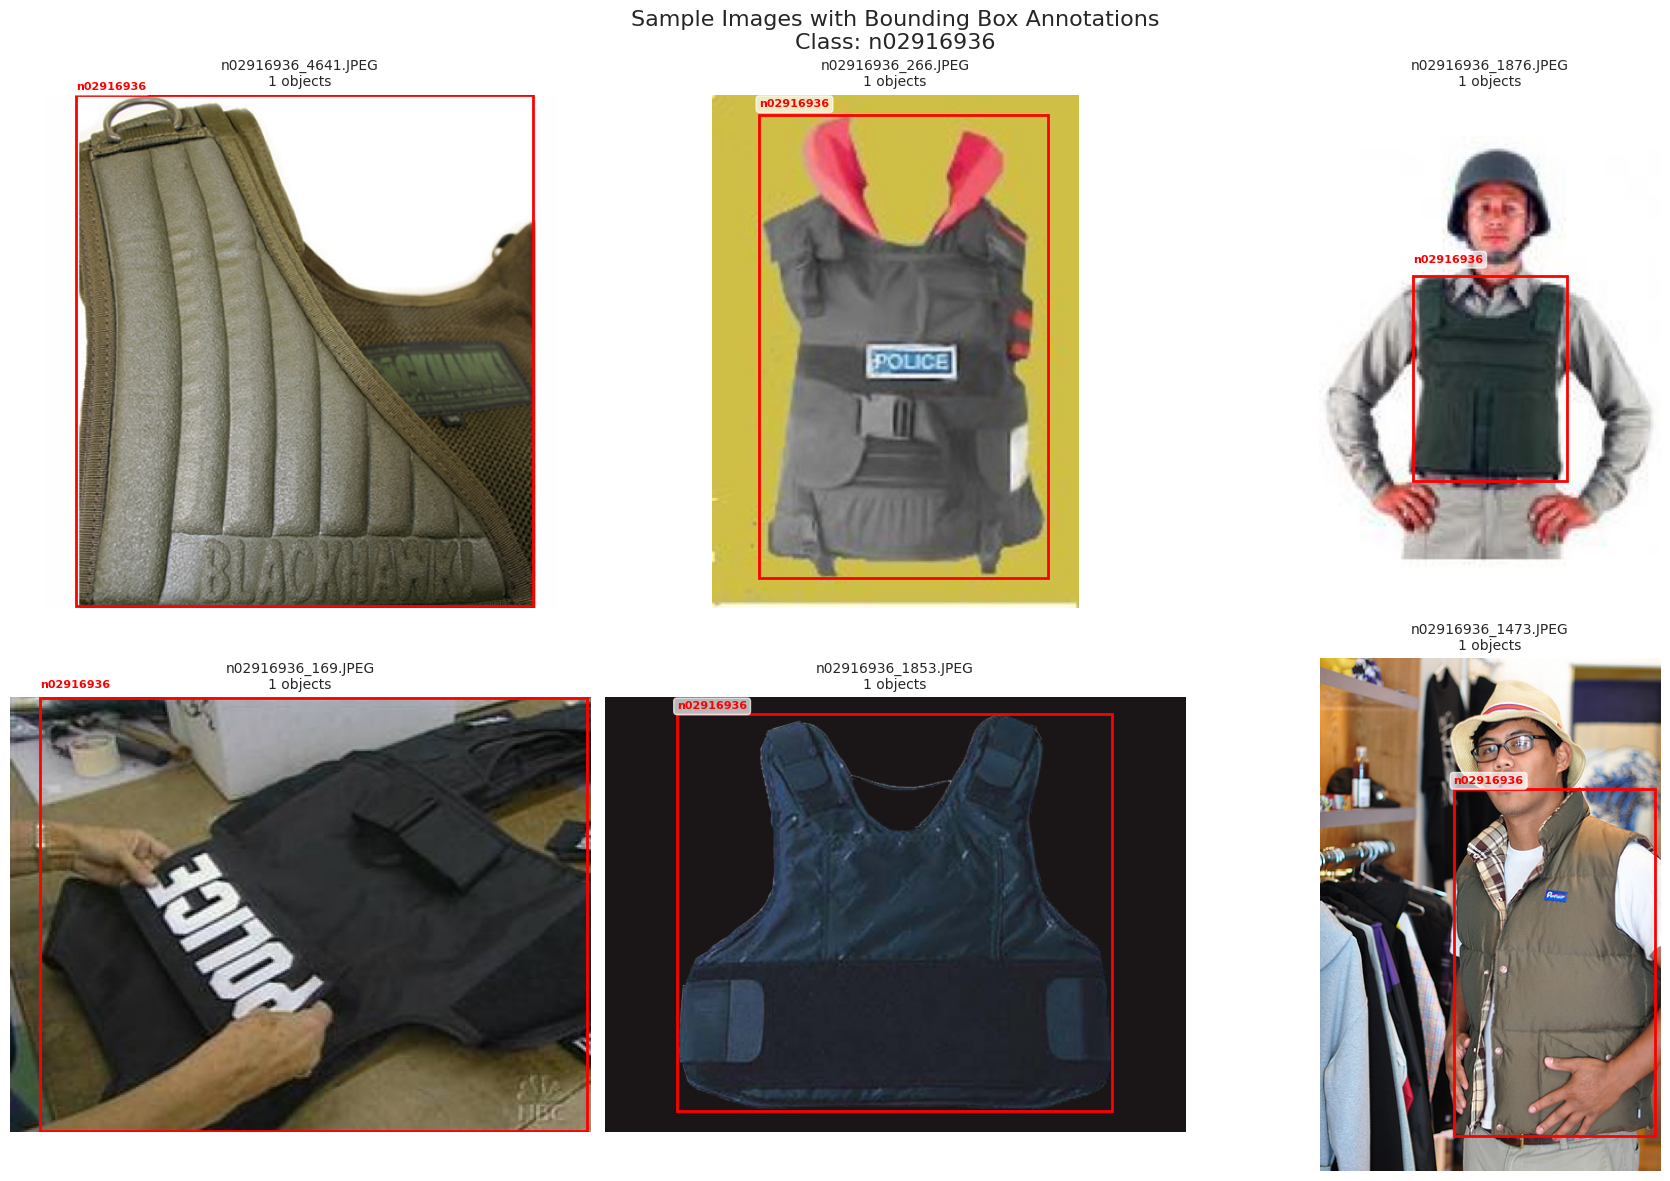


📋 Object Types Found:
  • n02916936: 6 instances


In [11]:
# Step 9.2: Improved Annotation Visualization with Better Image Matching

def find_matching_image(img_name, class_img_dir):
    """Find matching image file with flexible naming"""
    # Try exact match first
    exact_path = os.path.join(class_img_dir, img_name)
    if os.path.exists(exact_path):
        return exact_path
    
    # Try different extensions
    base_name = os.path.splitext(img_name)[0]
    extensions = ['.jpg', '.jpeg', '.png', '.JPEG', '.JPG', '.PNG', '.bmp', '.BMP']
    
    for ext in extensions:
        alt_path = os.path.join(class_img_dir, base_name + ext)
        if os.path.exists(alt_path):
            return alt_path
    
    # Try to find by base name (without extension matching)
    if os.path.exists(class_img_dir):
        for file in os.listdir(class_img_dir):
            if os.path.splitext(file)[0] == base_name:
                return os.path.join(class_img_dir, file)
    
    return None

def explore_annotations_improved(num_samples=6):
    """Improved annotation exploration with better error handling"""
    if not os.path.exists(TRAIN_ANNOTATIONS_DIR):
        print(f"❌ Training annotations directory not found: {TRAIN_ANNOTATIONS_DIR}")
        return
    
    print(f"✅ Training annotations directory found")
    
    # Get annotation classes
    ann_classes = [d for d in os.listdir(TRAIN_ANNOTATIONS_DIR) 
                  if os.path.isdir(os.path.join(TRAIN_ANNOTATIONS_DIR, d))]
    
    if not ann_classes:
        print("❌ No annotation class directories found")
        return
    
    # Try multiple classes to find one with matching images
    successful_class = None
    annotations = []
    
    for sample_class in ann_classes[:5]:  # Try first 5 classes
        class_ann_dir = os.path.join(TRAIN_ANNOTATIONS_DIR, sample_class)
        class_img_dir = os.path.join(TRAIN_DIR, sample_class)
        
        xml_files = [f for f in os.listdir(class_ann_dir) if f.endswith('.xml')]
        
        if not xml_files:
            continue
            
        print(f"📄 Checking class '{sample_class}' - {len(xml_files)} annotation files")
        
        # Try to find annotations with matching images
        sample_files = random.sample(xml_files, min(num_samples, len(xml_files)))
        temp_annotations = []
        
        for xml_file in sample_files:
            xml_path = os.path.join(class_ann_dir, xml_file)
            ann = parse_annotation_xml(xml_path)
            
            if ann:
                img_name = ann['filename']
                img_path = find_matching_image(img_name, class_img_dir)
                
                if img_path:
                    ann['img_path'] = img_path
                    temp_annotations.append(ann)
        
        if temp_annotations:
            successful_class = sample_class
            annotations = temp_annotations
            print(f"✅ Found {len(annotations)} matching image-annotation pairs in class '{sample_class}'")
            break
        else:
            print(f"⚠️ No matching images found for class '{sample_class}'")
    
    if not annotations:
        print("❌ No matching image-annotation pairs found in any class")
        print("💡 This might mean:")
        print("   1. Image files are in a different location")
        print("   2. Image files have different naming convention")
        print("   3. Dataset structure is different than expected")
        return
    
    # Analyze and visualize
    print(f"\n📊 Annotation Analysis (Class: {successful_class}, {len(annotations)} files):")
    
    # Analyze object counts
    obj_counts = [len(ann['objects']) for ann in annotations]
    print(f"Objects per image - Min: {min(obj_counts)}, Max: {max(obj_counts)}, Mean: {np.mean(obj_counts):.1f}")
    
    # Create visualization
    cols = 3
    rows = 2
    fig, axes = plt.subplots(rows, cols, figsize=(18, 12))
    axes = axes.flatten()
    
    for i, ann in enumerate(annotations[:rows*cols]):
        try:
            # Load image
            img = Image.open(ann['img_path'])
            axes[i].imshow(img)
            
            # Draw bounding boxes
            for obj in ann['objects']:
                rect = patches.Rectangle(
                    (obj['xmin'], obj['ymin']),
                    obj['width'], obj['height'],
                    linewidth=2, edgecolor='red', facecolor='none'
                )
                axes[i].add_patch(rect)
                
                # Add label
                axes[i].text(obj['xmin'], obj['ymin']-5, obj['name'], 
                           color='red', fontsize=8, weight='bold',
                           bbox=dict(boxstyle="round,pad=0.3", facecolor='white', alpha=0.7))
            
            # Set title
            img_filename = os.path.basename(ann['img_path'])
            axes[i].set_title(f"{img_filename}\n{len(ann['objects'])} objects", fontsize=10)
            axes[i].axis('off')
            
            img.close()
            
        except Exception as e:
            axes[i].text(0.5, 0.5, f"Error displaying\n{os.path.basename(ann.get('img_path', 'unknown'))}\n{str(e)[:50]}", 
                       ha='center', va='center', transform=axes[i].transAxes, fontsize=8)
            axes[i].axis('off')
    
    # Hide unused subplots
    for i in range(len(annotations), rows*cols):
        axes[i].axis('off')
    
    plt.suptitle(f'Sample Images with Bounding Box Annotations\nClass: {successful_class}', fontsize=16)
    plt.tight_layout()
    plt.show()
    
    # Print object statistics
    if annotations:
        all_objects = []
        for ann in annotations:
            all_objects.extend(ann['objects'])
        
        if all_objects:
            object_names = [obj['name'] for obj in all_objects]
            object_counts = Counter(object_names)
            
            print(f"\n📋 Object Types Found:")
            for obj_name, count in object_counts.most_common(10):
                print(f"  • {obj_name}: {count} instances")

# Run improved annotation exploration
print("🔍 Exploring annotations with improved matching...")
explore_annotations_improved(num_samples=6)

In [12]:
# Step 9.1: Debug Annotation and Image Matching

def debug_annotation_image_matching():
    """Debug why annotation visualization is empty"""
    print("🔍 Debugging annotation and image file matching...")
    
    if not os.path.exists(TRAIN_ANNOTATIONS_DIR):
        print("❌ Training annotations directory not found")
        return
    
    # Get first annotation class
    ann_classes = [d for d in os.listdir(TRAIN_ANNOTATIONS_DIR) 
                  if os.path.isdir(os.path.join(TRAIN_ANNOTATIONS_DIR, d))]
    
    if not ann_classes:
        print("❌ No annotation class directories found")
        return
    
    sample_class = ann_classes[0]
    print(f"🔍 Debugging class: {sample_class}")
    
    # Check annotation files
    class_ann_dir = os.path.join(TRAIN_ANNOTATIONS_DIR, sample_class)
    xml_files = [f for f in os.listdir(class_ann_dir) if f.endswith('.xml')]
    print(f"📄 Found {len(xml_files)} XML annotation files")
    
    # Check corresponding image directory
    class_img_dir = os.path.join(TRAIN_DIR, sample_class)
    print(f"📁 Image directory: {class_img_dir}")
    print(f"📁 Image directory exists: {os.path.exists(class_img_dir)}")
    
    if os.path.exists(class_img_dir):
        img_files = [f for f in os.listdir(class_img_dir) 
                    if f.lower().endswith(('.jpg', '.jpeg', '.png'))]
        print(f"🖼️ Found {len(img_files)} image files")
        
        # Check first few annotation files to see image names
        sample_xml = xml_files[:3]
        print(f"\n🔍 Checking first 3 annotation files:")
        
        for xml_file in sample_xml:
            xml_path = os.path.join(class_ann_dir, xml_file)
            ann = parse_annotation_xml(xml_path)
            
            if ann:
                img_name = ann['filename']
                img_path = os.path.join(class_img_dir, img_name)
                
                print(f"  📄 {xml_file} -> 🖼️ {img_name}")
                print(f"      Image exists: {os.path.exists(img_path)}")
                
                # Check if image exists with different extensions
                base_name = os.path.splitext(img_name)[0]
                for ext in ['.jpg', '.jpeg', '.png', '.JPEG', '.JPG', '.PNG']:
                    alt_path = os.path.join(class_img_dir, base_name + ext)
                    if os.path.exists(alt_path):
                        print(f"      Found alternative: {base_name + ext}")
        
        # Show sample image files
        print(f"\n📋 Sample image files in directory:")
        for img in img_files[:5]:
            print(f"  🖼️ {img}")
    else:
        print("❌ Image directory doesn't exist")
        
        # Check what directories exist in TRAIN_DIR
        if os.path.exists(TRAIN_DIR):
            train_dirs = [d for d in os.listdir(TRAIN_DIR) 
                         if os.path.isdir(os.path.join(TRAIN_DIR, d))]
            print(f"\n📁 Available training directories ({len(train_dirs)}):")
            for d in train_dirs[:10]:  # Show first 10
                print(f"  📂 {d}")
        else:
            print("❌ TRAIN_DIR doesn't exist")

# Run debug
debug_annotation_image_matching()

🔍 Debugging annotation and image file matching...
🔍 Debugging class: n02916936
📄 Found 431 XML annotation files
📁 Image directory: /home/ubuntu/Downloads/ILSVRC/Data/CLS-LOC/train/n02916936
📁 Image directory exists: True
🖼️ Found 1176 image files

🔍 Checking first 3 annotation files:
  📄 n02916936_7098.xml -> 🖼️ n02916936_7098
      Image exists: False
      Found alternative: n02916936_7098.JPEG
  📄 n02916936_1151.xml -> 🖼️ n02916936_1151
      Image exists: False
      Found alternative: n02916936_1151.JPEG
  📄 n02916936_9435.xml -> 🖼️ n02916936_9435
      Image exists: False
      Found alternative: n02916936_9435.JPEG

📋 Sample image files in directory:
  🖼️ n02916936_1769.JPEG
  🖼️ n02916936_3781.JPEG
  🖼️ n02916936_559.JPEG
  🖼️ n02916936_976.JPEG
  🖼️ n02916936_8261.JPEG


In [13]:
# Step 10: Dataset Summary and Next Steps

def print_dataset_summary():
    """Print a comprehensive summary of the dataset exploration"""
    print("🎯 ImageNet Dataset Exploration Summary")
    print("=" * 60)
    
    # Check what we found
    found_components = []
    missing_components = []
    
    components = {
        "Training Images": TRAIN_DIR,
        "Validation Images": VAL_DIR,
        "Test Images": TEST_DIR,
        "Training Annotations": TRAIN_ANNOTATIONS_DIR,
        "Validation Annotations": VAL_ANNOTATIONS_DIR,
        "ImageSets": IMAGESETS_DIR
    }
    
    for name, path in components.items():
        if os.path.exists(path):
            found_components.append(name)
        else:
            missing_components.append(name)
    
    print(f"✅ Found Components ({len(found_components)}):")
    for component in found_components:
        print(f"   • {component}")
    
    if missing_components:
        print(f"\n❌ Missing Components ({len(missing_components)}):")
        for component in missing_components:
            print(f"   • {component}")
    
    print(f"\n📊 Quick Stats:")
    if os.path.exists(TRAIN_DIR):
        train_classes = [d for d in os.listdir(TRAIN_DIR) 
                        if os.path.isdir(os.path.join(TRAIN_DIR, d))]
        print(f"   • Training classes: {len(train_classes)}")
    
    if os.path.exists(VAL_DIR):
        val_images = [f for f in os.listdir(VAL_DIR) 
                     if f.lower().endswith(('.jpg', '.jpeg', '.png'))]
        print(f"   • Validation images: {len(val_images):,}")
    
    if os.path.exists(TEST_DIR):
        test_images = [f for f in os.listdir(TEST_DIR) 
                      if f.lower().endswith(('.jpg', '.jpeg', '.png'))]
        print(f"   • Test images: {len(test_images):,}")
    
    print(f"\n🎯 Dataset is ready for:")
    print(f"   • Image classification tasks")
    if os.path.exists(TRAIN_ANNOTATIONS_DIR):
        print(f"   • Object detection/localization tasks")
    print(f"   • Transfer learning experiments")
    print(f"   • Computer vision research")
    
    print(f"\n📚 Next Steps:")
    print(f"   1. Load specific classes for your task")
    print(f"   2. Implement data loaders (PyTorch/TensorFlow)")
    print(f"   3. Apply data augmentation techniques")
    print(f"   4. Train/fine-tune deep learning models")
    print(f"   5. Evaluate on validation/test sets")

# Print summary
print_dataset_summary()

🎯 ImageNet Dataset Exploration Summary
✅ Found Components (6):
   • Training Images
   • Validation Images
   • Test Images
   • Training Annotations
   • Validation Annotations
   • ImageSets

📊 Quick Stats:
   • Training classes: 1000
   • Validation images: 50,000
   • Test images: 100,000

🎯 Dataset is ready for:
   • Image classification tasks
   • Object detection/localization tasks
   • Transfer learning experiments
   • Computer vision research

📚 Next Steps:
   1. Load specific classes for your task
   2. Implement data loaders (PyTorch/TensorFlow)
   3. Apply data augmentation techniques
   4. Train/fine-tune deep learning models
   5. Evaluate on validation/test sets


## 🚀 Usage Examples

### Loading Data with PyTorch
```python
import torch
from torchvision import datasets, transforms

# Define transforms
transform = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], 
                        std=[0.229, 0.224, 0.225])
])

# Load dataset
train_dataset = datasets.ImageFolder(TRAIN_DIR, transform=transform)
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=32, shuffle=True)
```

### Custom Dataset Class
```python
class ImageNetDataset(torch.utils.data.Dataset):
    def __init__(self, image_dir, transform=None):
        self.image_dir = image_dir
        self.transform = transform
        # Implement your custom loading logic
        
    def __len__(self):
        return len(self.image_paths)
        
    def __getitem__(self, idx):
        # Load image and apply transforms
        return image, label
```

---

**Dataset Path**: `/home/ubuntu/Downloads/ILSVRC`  
**Notebook**: ImageNet Dataset Explorer  
**Last Updated**: October 2025